## Loading in Dependencies and downloading common libraries
This will install catboost on your notebook instance
. I recommend opening in google collab for optimal results. Further if you want to see the model results but not the processing / training steps, scroll down.

Dependencies: 
- CatBoost
- Category Encoders 
- Pandas
- Numpy 
- Sklearn

If you do not have Catboost or Category Encoders on your machine use pip install in the notebook

Example:
- pip install CatBoost
- pip install category_encoders

## Loading Libraries, Processing, Cleaning and Training

In [75]:
import pandas as pd
import numpy as np

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from category_encoders.quantile_encoder import QuantileEncoder

In [78]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [79]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [80]:
def metric_scoring(classifier, x_test_data, y_test_data, model_name):
  y_true = y_test_data
  y_pred = classifier.predict(x_test_data)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  metric_data = {
    'Model Name': model_name,
    'Precision' : round(precision,4),
    'Recall' : round(recall,4),
    'Accuracy': round(accuracy,4),
    'F1 Score': round(f1,4)
  }
  return metric_data

### Data Links (Download and then upload to cloud instance)

### Train Data 

Processed X Train Data: https://github.com/noahruiz416/UFC-Fight-Prediction-Application-Model/blob/main/Data/X_processed_train.csv

Processed y Train Data: https://github.com/noahruiz416/UFC-Fight-Prediction-Application-Model/blob/main/Data/y_processed_train.csv

### Test Data:

Processed X Test Data: https://github.com/noahruiz416/UFC-Fight-Prediction-Application-Model/blob/main/Data/X_processed_test.csv

Processed y Test Data: https://github.com/noahruiz416/UFC-Fight-Prediction-Application-Model/blob/main/Data/y_test_data.csv

Loading in Data For Training

In [81]:
X_train = pd.read_csv('X_processed_train.csv', index_col=0)
y_train = pd.read_csv('y_processed_train.csv', index_col=0)

Binarizing our target varaible, 1 indicates red winner, 0 indicates blue winner

In [82]:
y_train = preprocessing.LabelBinarizer().fit_transform(y_train['Winner'])

inarizing our title bout field in the training data, 1 indicates title, 0 non title fight

In [83]:
X_train['title_bout'] = preprocessing.LabelBinarizer().fit_transform(X_train['title_bout'])

efining our categorical indices for catboost and numeric values for further processing

In [84]:
categorical_features_indices = ["R_fighter", "B_fighter", "Referee", "location", "weight_class", "B_Stance", "R_Stance"]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

reating the pipelines for each model, for RV, SVM and Logistc we will use Quantile Encoding<br>
or catboost, the model inherently handles categorical features

In [85]:
X_train_numeric = X_train.select_dtypes(include = numerics)
X_train_cat = X_train.select_dtypes(include = 'object')

In [86]:
scaler = StandardScaler()
encoder = QuantileEncoder()

Scaling Numeric Data

In [87]:
scaled_train = scaler.fit_transform(X_train_numeric.values)
scaled_train_df = pd.DataFrame(scaled_train, index=X_train_numeric.index, columns=X_train_numeric.columns)

Encoding Numeric Data

In [88]:
encoded_cat_data_train = encoder.fit_transform(X_train_cat, y_train)

We need to keep the X_train non cat data different from the catboost data since catboost deals with categorical variables implicitly<br>
R, RF and SVC do not so we scale and process

In [89]:
X_train_non_cat = scaled_train_df.join(encoded_cat_data_train)

Classifiers

In [90]:
logit =  LogisticRegression()
RF = RandomForestClassifier()
SVC = SVC()
Cat = CatBoostClassifier(cat_features = categorical_features_indices)
gradient_boosting = GradientBoostingClassifier()

In [91]:
classifiers_non_cat = [logit, RF, SVC, gradient_boosting]

Fitting Baseline Logistic, RF and SVC

In [92]:
for model in classifiers_non_cat:
    model.fit(X_train_non_cat, y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Fitting Catboost

In [93]:
Cat.fit(X_train, y_train)

Learning rate set to 0.020432
999:	learn: 0.2934448	total: 52.4s	remaining: 0us


In order to help prevent data leakage we load our test data after the models are trained

In [94]:
X_test = pd.read_csv('X_processed_test.csv', index_col=0)
y_test = pd.read_csv('y_processed_test.csv', index_col=0)

To enable proper modeling, we binarize our winner column 1 indicates red corner wins, 0 indicates blue corner wins

In [95]:
y_test = preprocessing.LabelBinarizer().fit_transform(y_test['Winner'])

Binarizing our title bout field in the training data, 1 indicates title, 0 non title fight

In [96]:
X_test['title_bout'] = preprocessing.LabelBinarizer().fit_transform(X_test['title_bout'])

Processing X_test data

In [97]:
X_test_numeric = X_test.select_dtypes(include = numerics)
X_test_cat = X_test.select_dtypes(include = 'object')

In [98]:
scaler = StandardScaler()

caling our test data

In [99]:
scaled_test = scaler.fit_transform(X_test_numeric.values)
scaled_test_df = pd.DataFrame(scaled_test, index=X_test_numeric.index, columns=X_test_numeric.columns)

To prevent target leakage fit the old transformer on the test data

In [100]:
encoded_cat_data = encoder.transform(X_test_cat)

Joining encoded and scaled data together

In [101]:
X_test_numerical = scaled_test_df.join(encoded_cat_data)

Metric scores for baseline models

In [102]:
lr_base_metric = metric_scoring(classifiers_non_cat[0], X_test_numerical, y_test, 'Logistic Regression')

In [103]:
rf_base_metric = metric_scoring(classifiers_non_cat[1], X_test_numerical, y_test, 'Random Forest Classifier')

In [104]:
svc_base_metric = metric_scoring(classifiers_non_cat[2], X_test_numerical, y_test, 'Support Vector Classifier')

In [105]:
gb_base_metric = metric_scoring(classifiers_non_cat[3], X_test_numerical, y_test, 'Gradient Boosting Classifier')

In [106]:
cat_base_metric = metric_scoring(Cat, X_test, y_test, 'CatBoost Classifier')

In [107]:
metrics = [lr_base_metric,rf_base_metric,svc_base_metric,cat_base_metric,gb_base_metric]

In [108]:
lr_df = pd.DataFrame.from_dict(metrics[0], orient = 'index').T
rf_df = pd.DataFrame.from_dict(metrics[1], orient = 'index').T
svc_df = pd.DataFrame.from_dict(metrics[2], orient = 'index').T
cat_df = pd.DataFrame.from_dict(metrics[3], orient = 'index').T
gb_df = pd.DataFrame.from_dict(metrics[4], orient = 'index').T

In [109]:
baseline_model_results = pd.concat([lr_df, rf_df, svc_df, cat_df,gb_df]).reset_index().drop(columns = 'index')

# Metric Scores and Results, Visuals - go here if you want to see the results of our baseline modeling and do not care about the processing and cleaning

In [110]:
baseline_model_results

,Model Name,Precision,Recall,Accuracy,F1 Score
0,Logistic Regression,0.7126,0.7971,0.6562,0.7525
1,Random Forest Classifier,0.7116,0.8264,0.6667,0.7647
2,Support Vector Classifier,0.72,0.8643,0.6907,0.7856
3,CatBoost Classifier,0.7484,0.8509,0.7147,0.7963
4,Gradient Boosting Classifier,0.7087,0.7494,0.6338,0.7285


Visualizing our baseline models performance

In [111]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

Red corner is 1<br>
Blue corner is 0

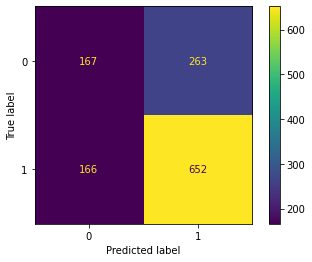

In [112]:
ConfusionMatrixDisplay.from_estimator(classifiers_non_cat[0], X_test_numerical, y_test)

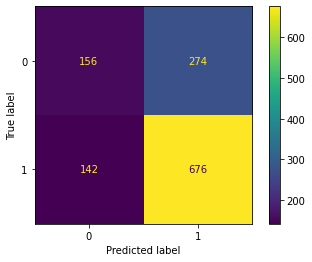

In [113]:
ConfusionMatrixDisplay.from_estimator(classifiers_non_cat[1], X_test_numerical, y_test)

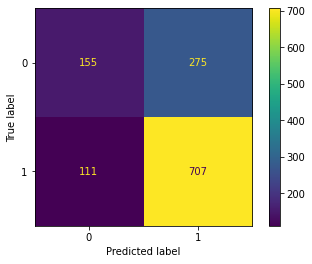

In [114]:
ConfusionMatrixDisplay.from_estimator(classifiers_non_cat[2], X_test_numerical, y_test)

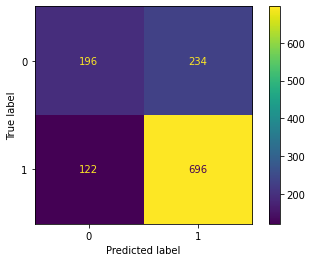

In [115]:
ConfusionMatrixDisplay.from_estimator(Cat, X_test, y_test)